<a href="https://colab.research.google.com/github/ssubedir/torch-deep-down/blob/main/Black_and_White.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Setup

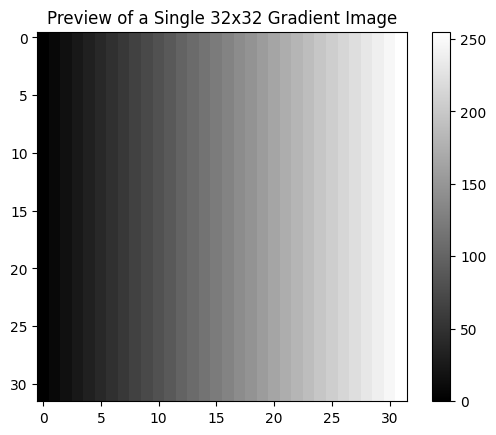

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Define the data generator function
def gray_gradient_generator(batch_size=10, num_batches=10):
    # Create a single 32x32 grayscale gradient from black to white
    gradient_32x32 = np.tile(np.linspace(0, 255, 32), (32, 1))

    # Stack 100 of these 32x32 gradients along a new axis
    gradient_stack = np.stack([gradient_32x32] * 100, axis=0)

    # Yield batches from the stack
    for i in range(0, num_batches * batch_size, batch_size):
        batch = gradient_stack[i:i + batch_size]
        yield batch

# Create the generator and get the first batch
generator = gray_gradient_generator(batch_size=5, num_batches=10)
first_batch = next(generator)

# Display the first image in the first batch
plt.imshow(first_batch[0], cmap='gray', vmin=0, vmax=255)
plt.colorbar()
plt.title("Preview of a Single 32x32 Gradient Image")
plt.show()

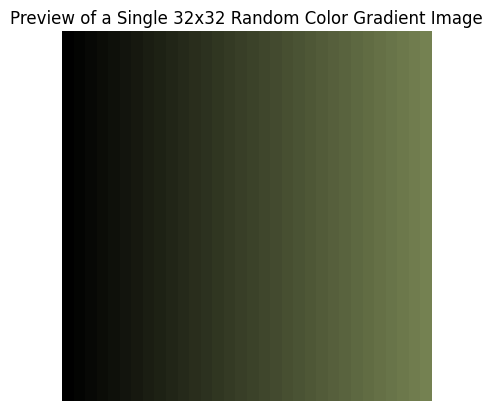

In [5]:
# Define the data generator function for random color gradients
def random_color_gradient_generator(batch_size=10, num_batches=10):
    # Each image will be a 32x32 gradient with random color channels
    gradient_stack = []
    for _ in range(100):  # Create 100 images
        # Create a gradient for each color channel (R, G, B) separately
        red_channel = np.tile(np.linspace(0, np.random.randint(50, 255), 32), (32, 1))
        green_channel = np.tile(np.linspace(0, np.random.randint(50, 255), 32), (32, 1))
        blue_channel = np.tile(np.linspace(0, np.random.randint(50, 255), 32), (32, 1))

        # Stack the channels along the last dimension to create a 32x32 RGB image
        color_gradient = np.stack([red_channel, green_channel, blue_channel], axis=-1)
        gradient_stack.append(color_gradient)

    # Stack all 100 color gradient images
    gradient_stack = np.stack(gradient_stack, axis=0)

    # Yield batches from the stack
    for i in range(0, num_batches * batch_size, batch_size):
        batch = gradient_stack[i:i + batch_size]
        yield batch

# Create the generator and get the first batch
color_generator = random_color_gradient_generator(batch_size=5, num_batches=10)
first_color_batch = next(color_generator)

# Display the first color gradient image in the first batch
plt.imshow(first_color_batch[0].astype(np.uint8))  # Convert to uint8 for proper color display
plt.title("Preview of a Single 32x32 Random Color Gradient Image")
plt.axis("off")
plt.show()

# Designing a Neural Network for 32x32 Color Gradient Images

To process 32x32 color gradient images, we can build a Convolutional Neural Network (CNN) that captures spatial patterns within these images. Here’s a step-by-step guide to designing the network layers:

## 1. Input Layer
- **Input Shape**: `(32, 32, 3)` where `3` represents the RGB color channels.

## 2. Convolutional Layers
- **Layer 1**: Start with a convolutional layer using small filters (e.g., `3x3` or `5x5`) and `32` filters to capture low-level features like edges and simple color gradients.
- **Layer 2**: Add a second convolutional layer with more filters (e.g., `64`) to detect more complex patterns.
- **Layer 3**: Optionally, add a third convolutional layer with even more filters (e.g., `128`) to detect higher-level features.

## 3. Pooling Layers
- After each convolutional layer, add a pooling layer (typically max-pooling with `2x2` filters) to reduce spatial dimensions and create shift-invariant features.
- After a few layers, pooling will reduce the 32x32 input size to a smaller, more manageable dimension (e.g., 4x4).

## 4. Flattening Layer
- After the final convolution and pooling operations, flatten the feature maps into a 1D vector, preparing the data for fully connected (dense) layers.

## 5. Fully Connected (Dense) Layers
- **Dense Layer 1**: Use a fully connected layer with a moderate number of neurons (e.g., `128`) to process the features extracted by the convolutional layers.
- **Dense Layer 2**: Optionally, add a second dense layer with fewer neurons (e.g., `64`) to refine the high-level features.
- **Dropout Layers**: Optionally, add dropout layers between dense layers to reduce overfitting.

## 6. Output Layer
- The design of the output layer depends on the task:
  - **Classification**: Use a dense layer with softmax activation for classifying different types of gradients.
  - **Regression**: Use a dense layer with linear activation for predicting properties of gradients.
  - **Autoencoder**: If the goal is to reconstruct the original image, add deconvolution or upsampling layers to match the output shape `(32, 32, 3)`.

## Summary
- Structure: **Input (32, 32, 3) → Conv Layers (with Pooling) → Flatten → Dense Layers → Output**
- Adding **Batch Normalization** layers after convolution layers and using **ReLU activation** will help stabilize training.

This layered approach leverages CNNs to effectively capture spatial patterns and features in 32x32 color gradient images.


# What do we have?


Input: 32x32 gradient

# What do we want?

Output: (Grayscale) or (notGrayScale)



**Preview**


---
```
Input Image (32x32x3):

Pixel (1,1) → [R1, G1, B1]   Pixel (1,2) → [R2, G2, B2]  ...
Pixel (2,1) → [R33, G33, B33]  Pixel (2,2) → [R34, G34, B34]  ...
...                      ...                        ...

Each pixel contains 3 values: [R, G, B] representing the RGB channels.
```







Since we have a picture, and by applying a convolutional layer, we can identify and analyze the features present in the image.



## Basic CNN Flow:

**Convolutional Layer**: This layer applies convolutional filters to the input image (or previous layer's output) to extract local features like edges, corners, and textures.

**Pooling Layer**: This layer reduces the spatial size (height and width) of the feature maps while retaining the important features. Pooling operations like max pooling help reduce computation and make the network more robust to small shifts or distortions in the image.

**Flatten Layer**: After the convolutional and pooling layers, the feature maps are flattened into a one-dimensional vector to be passed into fully connected layers.

**Fully Connected (Dense) Layer**: These layers process the flattened features and make the final predictions or classifications.

**Output Layer**: The final layer that produces the output (e.g., class probabilities for classification or a regression value).


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Define the data generator function for grayscale gradients
def gray_gradient_generator(batch_size=10, num_batches=10):
    gradient_32x32 = np.tile(np.linspace(0, 255, 32), (32, 1))
    gradient_stack = np.stack([gradient_32x32] * 100, axis=0)

    for i in range(0, num_batches * batch_size, batch_size):
        batch = gradient_stack[i:i + batch_size]
        yield batch

# Define the data generator function for random color gradients
def random_color_gradient_generator(batch_size=10, num_batches=10):
    gradient_stack = []
    for _ in range(100):  # Create 100 images
        red_channel = np.tile(np.linspace(0, np.random.randint(50, 255), 32), (32, 1))
        green_channel = np.tile(np.linspace(0, np.random.randint(50, 255), 32), (32, 1))
        blue_channel = np.tile(np.linspace(0, np.random.randint(50, 255), 32), (32, 1))
        color_gradient = np.stack([red_channel, green_channel, blue_channel], axis=-1)
        gradient_stack.append(color_gradient)

    gradient_stack = np.stack(gradient_stack, axis=0)

    for i in range(0, num_batches * batch_size, batch_size):
        batch = gradient_stack[i:i + batch_size]
        yield batch

# Set up the number of batches we want for each generator
num_batches = 500  # 100 batches of 10 images each
batch_size = 50

# Create the generators
gray_generator = gray_gradient_generator(batch_size=batch_size, num_batches=num_batches)
color_generator = random_color_gradient_generator(batch_size=batch_size, num_batches=num_batches)

# Function to create the dataset
def create_dataset(generator, num_batches, label, is_color=False):
    data = []
    labels = []
    for _ in range(num_batches):
        batch = next(generator)
        if not is_color:  # For grayscale images, convert to 3 channels
            batch = np.repeat(batch[..., np.newaxis], 3, axis=-1)  # Repeat grayscale across 3 channels
        data.append(batch)
        labels.append(np.full((batch.shape[0],), label))  # Label for the batch
    return np.vstack(data), np.concatenate(labels)

# Create the datasets
gray_data, gray_labels = create_dataset(gray_generator, num_batches, label=0, is_color=False)  # Label 0 for grayscale
color_data, color_labels = create_dataset(color_generator, num_batches, label=1, is_color=True)  # Label 1 for color

# Combine both datasets (grayscale and color)
data = np.vstack([gray_data, color_data])
labels = np.concatenate([gray_labels, color_labels])

# Shuffle the data to mix both grayscale and color images
indices = np.random.permutation(data.shape[0])
data = data[indices]
labels = labels[indices]

# Split into training and validation sets (80% training, 20% validation)
train_size = int(0.8 * data.shape[0])
X_train, X_val = data[:train_size], data[train_size:]
y_train, y_val = labels[:train_size], labels[train_size:]

# Check the shape of the data and the distribution of labels
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Training labels distribution: {np.bincount(y_train)}")
print(f"Validation labels distribution: {np.bincount(y_val)}")


Training data shape: (160, 32, 32, 3)
Validation data shape: (40, 32, 32, 3)
Training labels distribution: [79 81]
Validation labels distribution: [21 19]


# First Layer : convolutional (feature extration)

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the CNN architecture class
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # First convolutional layer (Input: 3 channels, Output: 32 filters, Kernel size: 3x3)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        # Apply the first convolutional layer followed by ReLU activation
        x = self.conv1(x)
        x = torch.relu(x)
        return x

# Initialize the CNN model
model = SimpleCNN()

# Print the model architecture
print(model)


SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


# Second layer: max pooling (down sample)

In [11]:
import torch
import torch.nn as nn

# Define the CNN architecture class
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # First convolutional layer (Input: 3 channels, Output: 32 filters, Kernel size: 3x3)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)

        # Max pooling layer (Pool size: 2x2, Stride: 2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        # Apply the first convolutional layer followed by ReLU activation
        x = self.conv1(x)
        x = torch.relu(x)

        # Apply max pooling
        x = self.pool(x)

        return x

# Initialize the CNN model
model = SimpleCNN()

# Print the model architecture
print(model)


SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


# Third layer: Flatten to dense

In [12]:
import torch
import torch.nn as nn

# Define the CNN architecture class
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # First convolutional layer (Input: 3 channels, Output: 32 filters, Kernel size: 3x3)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)

        # Max pooling layer (Pool size: 2x2, Stride: 2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layer (We'll define it after flattening)
        self.fc1 = nn.Linear(32 * 16 * 16, 64)  # Assuming the input is 32x32 and we used 2x2 max pooling

    def forward(self, x):
        # Apply the first convolutional layer followed by ReLU activation
        x = self.conv1(x)
        x = torch.relu(x)

        # Apply max pooling
        x = self.pool(x)

        # Flatten the output to feed into the fully connected layer
        x = torch.flatten(x, 1)  # Flatten all dimensions except the batch dimension

        # Pass the flattened data through the fully connected layer
        x = self.fc1(x)

        return x

# Initialize the CNN model
model = SimpleCNN()

# Print the model architecture
print(model)


SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=64, bias=True)
)


## Forth Layer: Dropout / More Dense

In [13]:
import torch
import torch.nn as nn

# Define the CNN architecture class
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # First convolutional layer (Input: 3 channels, Output: 32 filters, Kernel size: 3x3)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)

        # Max pooling layer (Pool size: 2x2, Stride: 2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layer (After flattening: 32 * 16 * 16 = 8192 input features)
        self.fc1 = nn.Linear(32 * 16 * 16, 64)

        # Dropout layer (probability of dropping out a unit is 0.5)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # Apply the first convolutional layer followed by ReLU activation
        x = self.conv1(x)
        x = torch.relu(x)

        # Apply max pooling
        x = self.pool(x)

        # Flatten the output to feed into the fully connected layer
        x = torch.flatten(x, 1)  # Flatten all dimensions except the batch dimension

        # Pass the flattened data through the fully connected layer
        x = self.fc1(x)

        # Apply dropout to the output of the fully connected layer
        x = self.dropout(x)

        return x

# Initialize the CNN model
model = SimpleCNN()

# Print the model architecture
print(model)


SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=64, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


## Fifth layer: Final layer (Binary classifier)

In [3]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn as nn
from sklearn.model_selection import train_test_split

# Assuming gray_data, color_data, gray_labels, and color_labels are already defined

# Combine both datasets (grayscale and color)
data = np.vstack([gray_data, color_data])  # Stack the grayscale and color images
labels = np.concatenate([gray_labels, color_labels])  # Concatenate the grayscale and color labels

# Split the data into training and validation sets (80% train, 20% validation)
train_data, val_data, train_labels, val_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

# Convert the numpy arrays to PyTorch tensors
train_data = torch.tensor(train_data, dtype=torch.float32)  # Shape: [num_train_samples, 3, 32, 32]
train_labels = torch.tensor(train_labels, dtype=torch.float32)  # Shape: [num_train_samples]
val_data = torch.tensor(val_data, dtype=torch.float32)  # Shape: [num_val_samples, 3, 32, 32]
val_labels = torch.tensor(val_labels, dtype=torch.float32)  # Shape: [num_val_samples]

# Ensure the input data has the correct shape: [batch_size, channels, height, width]
train_data = train_data.permute(0, 3, 1, 2)  # [batch_size, 3, 32, 32]
val_data = val_data.permute(0, 3, 1, 2)  # [batch_size, 3, 32, 32]

# Create DataLoader for batching
train_dataset = TensorDataset(train_data, train_labels)
val_dataset = TensorDataset(val_data, val_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


# Print the size of the training and validation data
print(f"Training data size: {train_data.size()}")
print(f"Training labels size: {train_labels.size()}")
print(f"Validation data size: {val_data.size()}")
print(f"Validation labels size: {val_labels.size()}")


# Define the CNN architecture class with binary classifier output layer
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # First convolutional layer (Input: 3 channels, Output: 32 filters, Kernel size: 3x3)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)

        # Max pooling layer (Pool size: 2x2, Stride: 2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layer (After flattening: 32 * 16 * 16 = 8192 input features)
        self.fc1 = nn.Linear(32 * 16 * 16, 64)

        # Dropout layer (probability of dropping out a unit is 0.5)
        self.dropout = nn.Dropout(p=0.5)

        # Output layer (1 neuron for binary classification)
        self.fc2 = nn.Linear(64, 1)  # 1 output unit for binary classification

        # Sigmoid activation is applied in the forward pass to the output layer

    def forward(self, x):
        # Apply the first convolutional layer followed by ReLU activation
        x = self.conv1(x)
        x = torch.relu(x)

        # Apply max pooling
        x = self.pool(x)

        # Flatten the output to feed into the fully connected layer
        x = torch.flatten(x, 1)  # Flatten all dimensions except the batch dimension

        # Pass the flattened data through the fully connected layer
        x = self.fc1(x)

        # Apply dropout to the output of the fully connected layer
        x = self.dropout(x)

        # Pass through the second fully connected layer (output layer)
        x = self.fc2(x)

        # Apply sigmoid activation to get probability between 0 and 1
        x = torch.sigmoid(x)

        return x

# Initialize the CNN model
model = SimpleCNN()

# Print the model architecture
print(model)


Training data size: torch.Size([160, 3, 32, 32])
Training labels size: torch.Size([160])
Validation data size: torch.Size([40, 3, 32, 32])
Validation labels size: torch.Size([40])
SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=64, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


## Train

In [4]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn.functional as F

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Assume `train_data` and `val_data` are the training and validation datasets
# Create DataLoader for batching
train_dataset = TensorDataset(train_data, train_labels)  # train_data and train_labels should be PyTorch tensors
val_dataset = TensorDataset(val_data, val_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        # Training step
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs.squeeze(), labels.float())  # Squeeze output to match the shape of labels

            # Backward pass (compute gradients)
            loss.backward()

            # Update weights
            optimizer.step()

            # Track loss and accuracy
            running_loss += loss.item()

            # Convert output probabilities to class labels (threshold at 0.5)
            predicted_labels = (outputs > 0.5).float()
            correct_preds += (predicted_labels.squeeze() == labels).sum().item()
            total_preds += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct_preds / total_preds

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

        # Validation step (evaluate model performance on validation set)
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        val_correct_preds = 0
        val_total_preds = 0

        with torch.no_grad():  # No need to compute gradients during validation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels.float())
                val_loss += loss.item()

                predicted_labels = (outputs > 0.5).float()
                val_correct_preds += (predicted_labels.squeeze() == labels).sum().item()
                val_total_preds += labels.size(0)

        val_loss /= len(val_loader)
        val_accuracy = 100 * val_correct_preds / val_total_preds

        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Start training
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

Epoch [1/10], Loss: 47.0634, Accuracy: 48.12%
Validation Loss: 46.8750, Validation Accuracy: 47.50%
Epoch [2/10], Loss: 48.7500, Accuracy: 51.25%
Validation Loss: 46.8750, Validation Accuracy: 47.50%
Epoch [3/10], Loss: 49.3750, Accuracy: 50.62%
Validation Loss: 46.8750, Validation Accuracy: 47.50%
Epoch [4/10], Loss: 49.3750, Accuracy: 50.62%
Validation Loss: 46.8750, Validation Accuracy: 47.50%
Epoch [5/10], Loss: 49.3750, Accuracy: 50.62%
Validation Loss: 46.8750, Validation Accuracy: 47.50%
Epoch [6/10], Loss: 49.3750, Accuracy: 50.62%
Validation Loss: 46.8750, Validation Accuracy: 47.50%
Epoch [7/10], Loss: 49.3750, Accuracy: 50.62%
Validation Loss: 46.8750, Validation Accuracy: 47.50%
Epoch [8/10], Loss: 49.3750, Accuracy: 50.62%
Validation Loss: 46.8750, Validation Accuracy: 47.50%
Epoch [9/10], Loss: 49.3750, Accuracy: 50.62%
Validation Loss: 46.8750, Validation Accuracy: 47.50%
Epoch [10/10], Loss: 49.3750, Accuracy: 50.62%
Validation Loss: 46.8750, Validation Accuracy: 47.50%

# Inference

In [ ]:
import torch

# Function to run inference on a single batch of data
def run_inference(model, data, device):
    model.eval()  # Set model to evaluation mode (important for inference)

    # Ensure the input data is a PyTorch tensor and move to the correct device
    data = torch.tensor(data, dtype=torch.float32).to(device)

    with torch.no_grad():  # No need to calculate gradients during inference
        # Forward pass through the model
        outputs = model(data)

        # Convert outputs (probabilities) to class predictions (0 or 1)
        predictions = (outputs > 0.5).float()  # Threshold at 0.5 for binary classification

    return predictions

# Example usage for a batch of validation data (assuming 'val_data' is a NumPy array)
predictions = run_inference(model, val_data, device)

# Example: Print the first few predictions
print(predictions[:10])


# Infrence

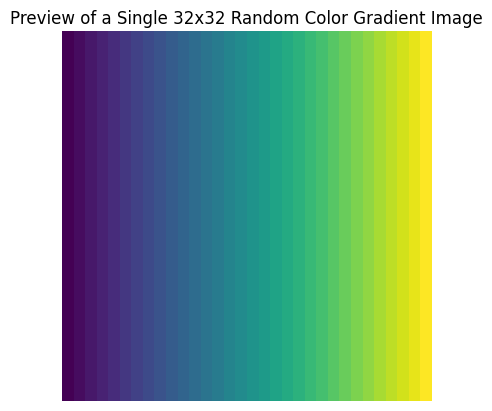

In [21]:
# Create the generator and get the first batch
# color_generator = random_color_gradient_generator(batch_size=5, num_batches=10)
color_generator = gray_gradient_generator(batch_size=5, num_batches=10)
grad_batch = next(color_generator)
grad_color = grad_batch[0]

# Display the first color gradient image in the first batch
plt.imshow(grad_color.astype(np.uint8))  # Convert to uint8 for proper color display
plt.title("Preview of a Single 32x32 Random Color Gradient Image")
plt.axis("off")
plt.show()

In [22]:
# Convert the numpy array to a PyTorch tensor and add the batch dimension
gradient_tensor = torch.tensor(grad_color, dtype=torch.float32).unsqueeze(0)  # Shape: [1, 32, 32, 3]

# Correct the shape by permuting the dimensions to [1, 3, 32, 32]
gradient_tensor = gradient_tensor.permute(0, 3, 1, 2)  # Shape: [1, 3, 32, 32]

# Move the tensor to the correct device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gradient_tensor = gradient_tensor.to(device)

# Set the model to evaluation mode (important during inference)
model.eval()

# Perform inference with the trained model
with torch.no_grad():
    output = model(gradient_tensor)

# The model output is a probability between 0 and 1 (since you're using a sigmoid activation)
predicted_label = (output > 0.5).float()  # Threshold at 0.5 for binary classification

# Print the predicted label (0 = Grayscale, 1 = Color)
print(f"Predicted label for the generated gradient: {'Color' if predicted_label.item() == 1 else 'Grayscale'}")

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4